<a href="https://colab.research.google.com/github/zakkaria123/alternative_random_walk/blob/main/predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing All necessary Modules/Libraries


In [ ]:
#pip install azureml-core
#pip install os

In [ ]:
import requests,uuid,pandas as pd, numpy as np, seaborn as sms,matplotlib.pyplot as plt,joblib,h5py,tensorflow as tf,azureml
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sms.set(color_codes=True)
from numpy.random import seed
from tensorflow.keras.layers import Input,Dropout,Dense
from tensorflow.keras.models import Model,Sequential,load_model,model_from_json
from tensorflow.keras import regularizers
from azureml.core import Run,Workspace
from azureml.core.model import Model as AmlModel
from azureml.core.run import Run
from azureml.core.experiment import Experiment

## Data Acquistion and Cleaning
#### Visualizing the first data showing the Normal Behavior of the Motor/Pump set

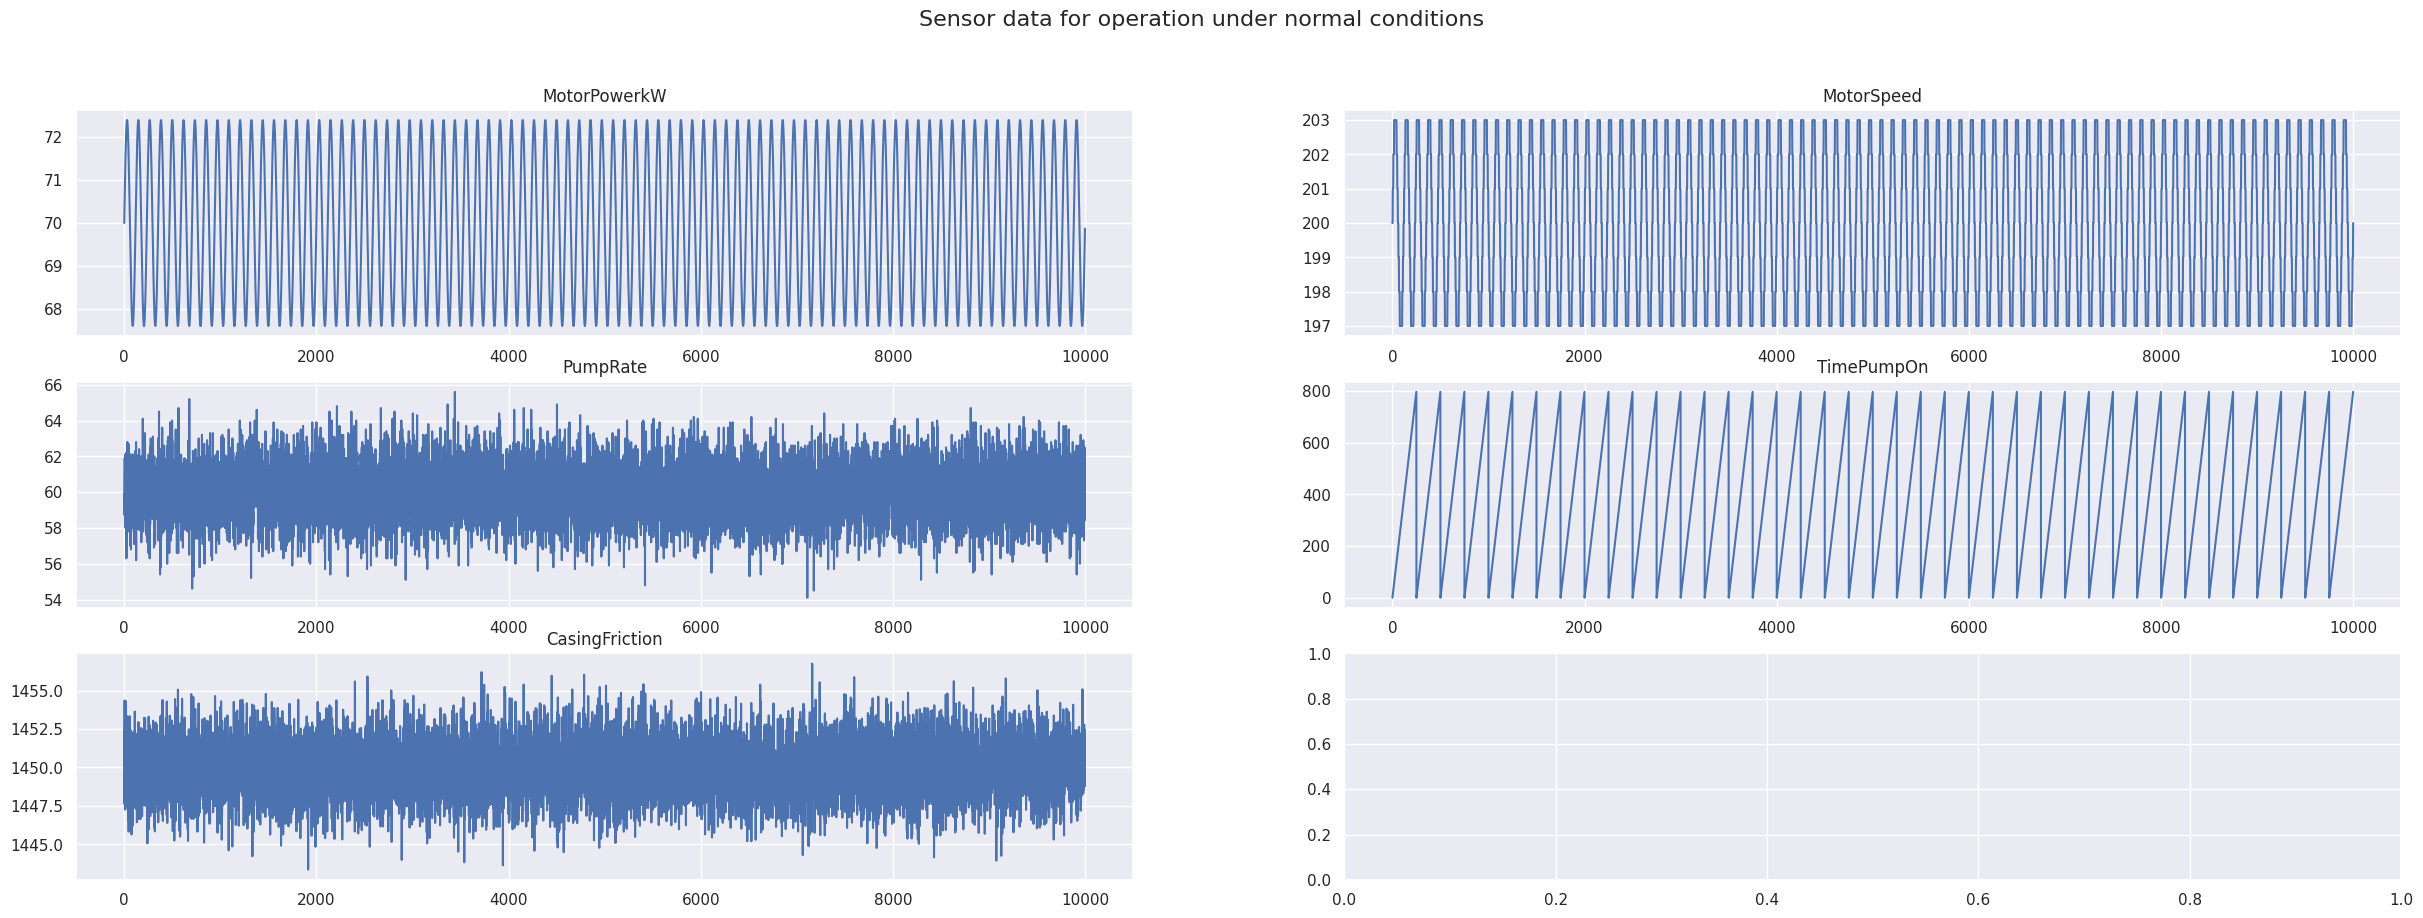

In [ ]:
pdNormal=pd.read_csv('/content/TelemetryNormal.csv')
pdGradualFailure=pd.read_csv('/content/TelemetryWithGradualFailures.csv')
pdImmediateFailure=pd.read_csv('/content/TelemetryWithImmediateFailures.csv')
def normal_sensor():
    fig,ax=plt.subplots(3,2,figsize=(30,10))
    ax[0][0].set_title('MotorPowerkW')
    ax[0][1].set_title('MotorSpeed')
    ax[1][0].set_title('PumpRate')
    ax[1][1].set_title('TimePumpOn')
    ax[2][0].set_title('CasingFriction')
    ax[0][0].plot(pdNormal['MotorPowerkW'])
    ax[0][1].plot(pdNormal['MotorSpeed'])
    ax[1][0].plot(pdNormal['PumpRate'])
    ax[1][1].plot(pdNormal['TimePumpOn'])
    ax[2][0].plot(pdNormal['CasingFriction'])
    fig.suptitle('Sensor data for operation under normal conditions',fontsize=16)
    plt.show()
normal_sensor()

#### Visualizing data showing Gradual Motor/PumpFailure

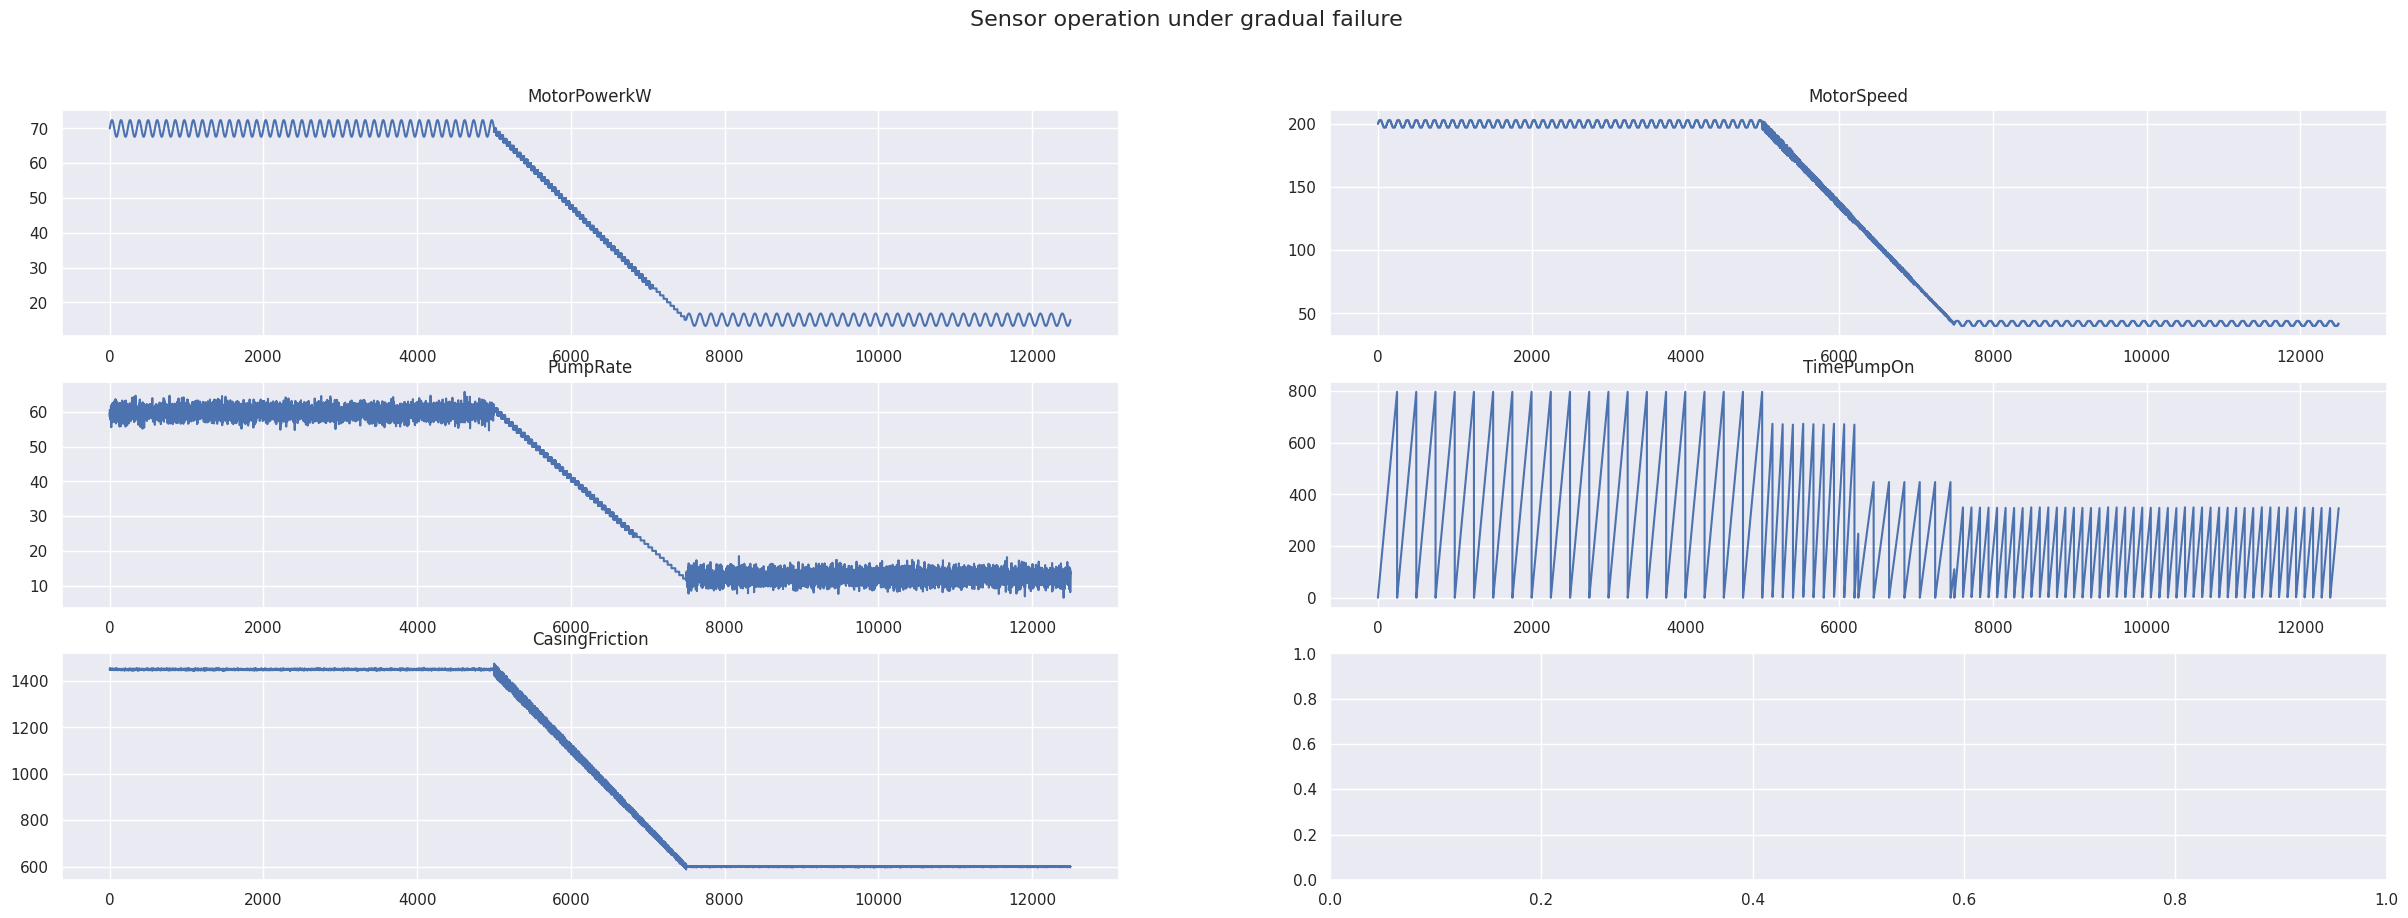

In [ ]:
def gradualfailure():
    fig,ax=plt.subplots(3,2,figsize=(30,10))
    ax[0][0].set_title('MotorPowerkW')
    ax[0][1].set_title('MotorSpeed')
    ax[1][0].set_title('PumpRate')
    ax[1][1].set_title('TimePumpOn')
    ax[2][0].set_title('CasingFriction')
    ax[0][0].plot(pdGradualFailure['MotorPowerkW'])
    ax[0][1].plot(pdGradualFailure['MotorSpeed'])
    ax[1][0].plot(pdGradualFailure['PumpRate'])
    ax[1][1].plot(pdGradualFailure['TimePumpOn'])
    ax[2][0].plot(pdGradualFailure['CasingFriction'])
    fig.suptitle('Sensor operation under gradual failure',fontsize=16)
    plt.show()
gradualfailure()

#### Visualizing Data showing Immediate Pump/Motor Failure

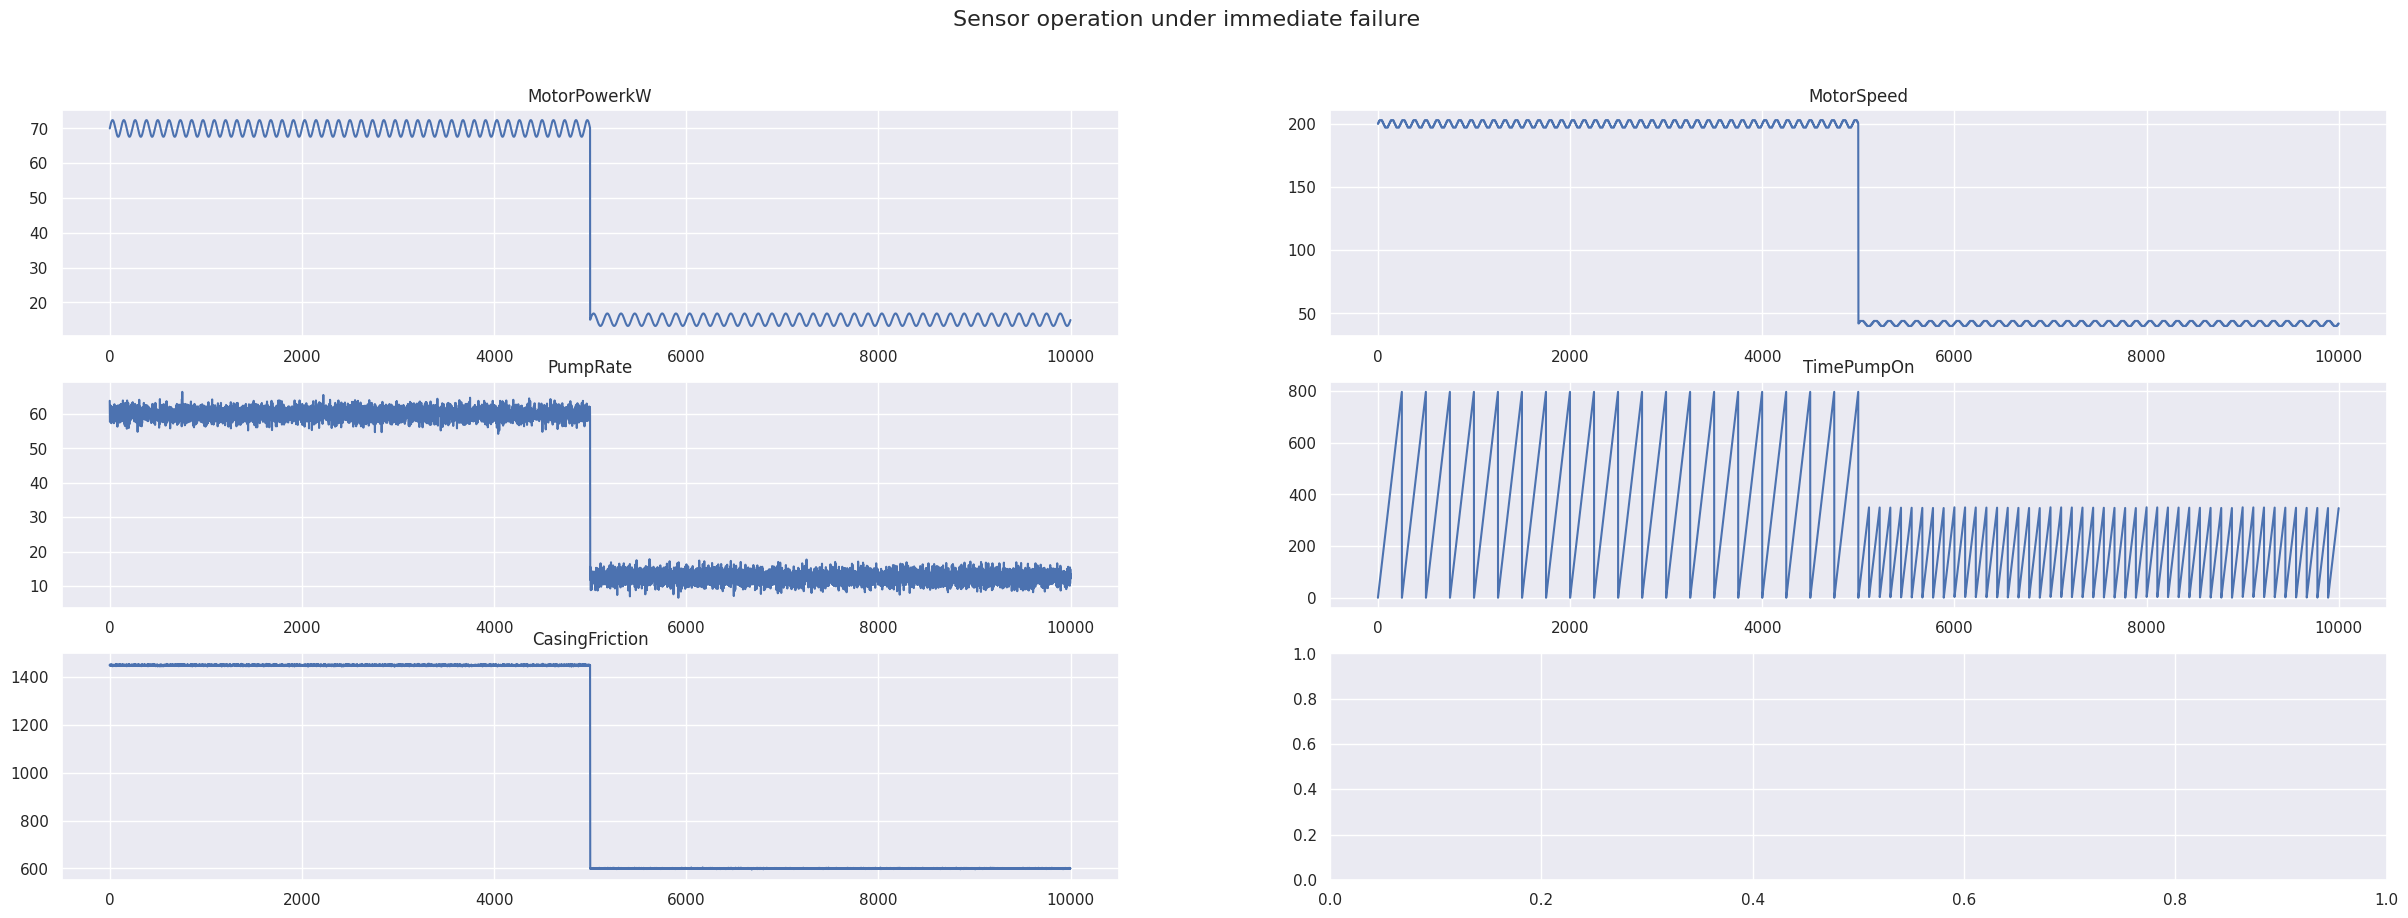

In [ ]:
def immediatefailure():
    fig,ax=plt.subplots(3,2,figsize=(30,10))
    ax[0][0].set_title('MotorPowerkW')
    ax[0][1].set_title('MotorSpeed')
    ax[1][0].set_title('PumpRate')
    ax[1][1].set_title('TimePumpOn')
    ax[2][0].set_title('CasingFriction')
    ax[0][0].plot(pdImmediateFailure['MotorPowerkW'])
    ax[0][1].plot(pdImmediateFailure['MotorSpeed'])
    ax[1][0].plot(pdImmediateFailure['PumpRate'])
    ax[1][1].plot(pdImmediateFailure['TimePumpOn'])
    ax[2][0].plot(pdImmediateFailure['CasingFriction'])
    fig.suptitle('Sensor operation under immediate failure',fontsize=16)
    plt.show()
immediatefailure()

#### Data Preprocessing

In [ ]:
scaler=preprocessing.MinMaxScaler()
X_train=pd.DataFrame(scaler.fit_transform(pdNormal),columns=pdNormal.columns,index=pdNormal.index)
joblib.dump(scaler,'scaler.pkl')
X_test1=pd.DataFrame(scaler.fit_transform(pdGradualFailure),columns=pdGradualFailure.columns,index=pdGradualFailure.index)
X_test2=pd.DataFrame(scaler.fit_transform(pdImmediateFailure),columns=pdImmediateFailure.columns,index=pdImmediateFailure.index)

#### Training and Validating the Neaural Network

In [ ]:
seed(10)
tf.random.set_seed(10)
act_func='elu'
input=Input(shape=(X_train.shape[1],))
x=Dense(100,activation=act_func,kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.0))(input)
x=Dense(50,activation=act_func,kernel_initializer='glorot_uniform')(x)
encoder=Dense(20,activation=act_func,kernel_initializer='glorot_uniform',name='feature_vector')(x)
x=Dense(50,activation=act_func,kernel_initializer='glorot_uniform')(encoder)
x=Dense(100,activation=act_func,kernel_initializer='glorot_uniform')(x)
output=Dense(X_train.shape[1],activation=act_func,kernel_initializer='glorot_uniform')(x)
model=Model(input,output)
model.compile(loss='mse',optimizer='adam')
encoder_model=Model(inputs=model.input,outputs=model.get_layer('feature_vector').output)
encoder_model.compile(loss='mse',optimizer='adam')
epochs=100
batch_size=10
history=model.fit(np.array(X_train),np.array(X_train),batch_size=batch_size,epochs=epochs,validation_split=0.05,verbose=1)

Epoch 1/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0108 - val_loss: 1.1188e-04
Epoch 2/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2795e-04 - val_loss: 6.4218e-05
Epoch 3/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0198e-04 - val_loss: 3.3469e-05
Epoch 4/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0947e-04 - val_loss: 2.6846e-05
Epoch 5/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0002e-04 - val_loss: 3.6876e-05
Epoch 6/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0221e-04 - val_loss: 2.8603e-05
Epoch 7/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.3427e-05 - val_loss: 2.6737e-05
Epoch 8/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.4232e-05 - val_loss: 1.8972e-05
Epoch 9/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.9040e-05 - val_loss: 1.9517e-05
Epoch 10/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.0601e-05 - val_loss: 3.4993e-05
Epoch 11/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

In [ ]:
def train():
    fig,ax=plt.subplots(1,1,figsize=(20,5))
    ax.set_title('Training/validation loss')
    plt.plot(history.history['val_loss'],'r',label='validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('loss, [mse]')
    plt.show()
train()

In [ ]:
def test_model():
    X_pred=model.predict(np.array(X_train))
    X_pred=pd.DataFrame(X_pred, columns=X_train.columns)
    X_pred.index=X_train.index
    scored=pd.DataFrame(index=X_train.index)
    scored['Loss_mae']=np.mean(np.abs(X_pred-X_train),axis=1)
    fig,ax=plt.subplots(1,1)
    sms.histplot(scored['Loss_mae'],bins=50,kde=True,color='blue')
    plt.xlim([0.0,0.02])
    plt.show()
test_model()